In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
    })

$$\Delta u = F\text{ in } (A,B)\times(C,D)$$

In [4]:
# Non-homogeneity
def F(x,y):
    return 4

# Boundary condition
def G(x,y):
    TOL = 0.01
    if np.abs(x*y) <TOL:
        return x**2+y**2
    if np.abs(x-1)<TOL or np.abs(y-1)<TOL:
        return (1-y)**2 + (1-x)**2
    else:
        return None

In [5]:
# returns a f, M-1xM-1 matrix with 0's on the boundary, and f[i,j] in between
# returns a g, MxM matrix, with NaN in i
# WARNING: The indices are one to the left, one to the top,
    # than the x they correspond to
def initial_f_and_g(F, G, x, y):
    M = len(x)-1
    f = [[F(x[i], y[j]) for j in range(1,M)] for i in range(1,M)]
    f = np.array(f)
    g = [[G(x[i], y[j]) for j in range(M+1)] for i in range(M+1)]
    g = np.array(g)
    
    return f, g

In [6]:
def buildB(M):
    B = 4*np.identity(M-1)
    for i in range(1,M-2):
        B[i, i-1] = -1
        B[i, i+1] = -1
    B[0,1] = B[-1,-2] = -1
    return B

In [7]:
def buildA(M):
    m = -np.identity(M-1)
    O = np.zeros((M-1, M-1))
    B = buildB(M)
    a = np.zeros((M-1, M-1), dtype='str')
    for i in range(M-1):
        for j in range(M-1):
            a[i,j]='O'
    for i in range(M-1):
        a[np.identity(M-1)==1]='B'
    for i in range(1, M-2):
        a[i, i+1] = a[i, i-1] = "m"
    a[0,1] = a[-1,-2] = 'm'
    a = ';'.join([','.join(a[i]) for i in range(M-1)])
    return (np.bmat(a))

In [8]:
# This builds the rhs we solve for
def buildbg(M, f, g, h):
    bg = np.zeros((M-1, M-1))
    for i in range(1, M):
        for j in range(1, M):
            i_index = i-1
            j_index = j-1
            bg[i_index, j_index] = -1 * h**2 * f[i_index,j_index]
            if i == 1:
                bg[i_index, j_index] += g[0, j]
            if j == 1:
                bg[i_index, j_index] += g[i, 0]
            if i == M-1:
                bg[i_index, j_index] += g[M, j]
            if j == M-1:
                bg[i_index, j_index] += g[i, M]
    return bg

Discretised operator $$P_h v = 
\frac{v_{i+1, j} - 2 v_{i,j} + v_{i-1, j}}{h^2}
+
\frac{v_{i, j+1} - 2 v_{i,j} + v_{i, j-1}}{h^2}
.$$
Implemented as $$ P_h v = \Big[4 v_{i,j} - v_{i+1, j} - v_{i-1, j} - v_{i,j+1} - v_{i,j-1}\Big]\frac{-1}{h^2}.$$

In [9]:
# Discretised operator
def P(v, M, h):
    Pv = np.zeros((M-1, M-1))
    for i in range(1,M):
        for j in range(1,M):
            Pv[i-1,j-1] = 4*v[i,j] - v[i+1,j] - v[i-1,j] - v[i,j+1] - v[i,j-1]
    Pv *= -1/(h**2)
    return Pv

In [10]:
def run(F, G, M, plot=True, save=True):
    a = 0
    b = 1
    c = 0
    d = 1

    LAMBDA = 1

    n_x = M+1 #int(np.abs(B-A)/h)+2
    n_y = n_x #int((T - T_0)/dt)+2

    x = np.linspace(a, b, n_x)
    y = np.linspace(c, d, n_y)
    h = x[1]-x[0]

    # Do I still need this?
    xx, yy = np.meshgrid(x,y)
    
    f, g = initial_f_and_g(F, G, x, y)
    A = buildA(M)
    bg = buildbg(M, f, g, h).flatten('F')
    
    u = np.linalg.inv(A)@bg
    u = np.reshape(u, (M-1, M-1), 'F')
    
    v = np.zeros((M+1,M+1))
    for i in range(0,M+1):
        for j in range(0, M+1):
            if g[i,j] != None:
                v[i,j] = g[i,j]
            else:
                v[i,j] = u[i-1, j-1]
    
    # If asked for a plot, then plot
    if plot:
        fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2)
        ax1.set_xlabel('$x$')
        ax1.set_ylabel('$y$')
        ax2.set_xlabel('$x$')
        ax2.set_ylabel('$y$')
        
        pos = ax1.imshow(v, extent=[x[0],x[-1],y[0],y[-1]], origin='lower')
        fig.colorbar(pos, ax=ax1)
        ax1.set_title(f"$M={M},\ h={round(h, 3)}$")
        
        pos2 = ax2.imshow(P(v, M, h)-f, extent=[a,b,c,d], origin='lower')
        fig.colorbar(pos2, ax=ax2)
        ax2.set_title(f"$P_h(v) - f$")
        
        if save:
            plt.savefig(f"hw1q5-{M}.pdf", bbox_inches='tight')
    return v

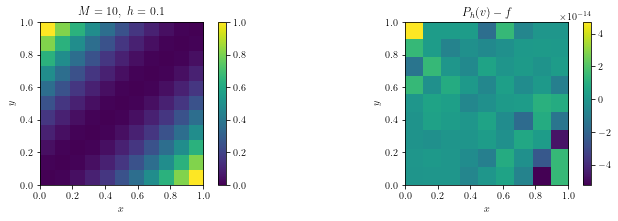

In [29]:
v = run(F, G, 10, save=False)

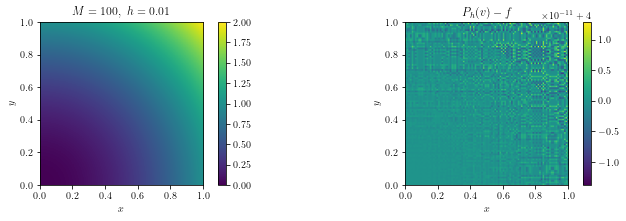

In [35]:
w = run(F=lambda x,y:0, G=lambda x,y: x**2+y**2, M=50, save=False)